### Use Random Forest to model Albert's data

This code does two things:
1.  Create a model based on training data
2.  Apply the model to a geomedian

The steps in this code are:

Create Model
1.  Import modules
2.  Import training data csv
3.  Create and evaluate model

Apply model
4.  Choose a location
5.  Import Landsat geomedians

#### Import modules

In [35]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


In [7]:
dc = datacube.Datacube(app='Alberts Forest')

#### Import training data csv

In [8]:
path = 'WCF_traindata_22102019.csv'
df = pd.read_csv(path)
df.head()

,WCF,blue,green,red,nir,swir1,swir2
0,0.261320,0.034313,0.047605,0.052131,0.19575,0.14400,0.082638
1,0.116210,0.044998,0.067579,0.083996,0.20979,0.25615,0.160270
2,0.408240,0.022349,0.035390,0.040748,0.19127,0.11858,0.070578
3,0.000000,0.048717,0.077072,0.091846,0.24272,0.29843,0.190590
4,0.053365,0.059975,0.087660,0.104420,0.23314,0.27891,0.184080


In [9]:
print('Min: ',df['WCF'].min())
print('Max: ',df['WCF'].max())

Min:  0.0
Max:  0.74829


#### Create and evaluate model

https://www.youtube.com/watch?v=YYjvkSJoui4 

In [10]:
# Handle misisng data
df = df.dropna()

# Define dependent variable
Y = df['WCF']

# Define independent variables
X = df.drop(labels=['WCF'],axis=1)

# Split model into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# Define model
model = RandomForestRegressor(n_estimators=10, random_state=30)

# Fit model
model.fit(X_train,Y_train)

# Predict test data
prediction_test = model.predict(X_test)

# Metrics
print('Accuracy = ')
print(metrics.explained_variance_score(Y_test, prediction_test)) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html

# Determine the importance of each of the bands
#print(model.feature_importances_) # need to format nicely
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)


Accuracy = 
0.8658457347096035
 red      0.613435
 nir      0.115798
 swir1    0.097775
 green    0.086500
blue      0.048595
 swir2    0.037898
dtype: float64


#### Choose location

Whroo in Victoria is the location of some training data

In [16]:
# Set the central latitude and longitude
central_lat = -36.70287 
central_lon = 145.01171

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


#### Import Landsat geomedians

In [56]:
product = "ls8_nbart_geomedian_annual"

measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition,spectral_definition
measurement,,,,,,,
blue,blue,int16,1,-999,NaN,NaN,NaN
green,green,int16,1,-999,NaN,NaN,NaN
red,red,int16,1,-999,NaN,NaN,NaN
nir,nir,int16,1,-999,NaN,NaN,NaN
swir1,swir1,int16,1,-999,NaN,NaN,NaN
swir2,swir2,int16,1,-999,NaN,NaN,NaN


In [18]:
resolution=(-10, 10)
time_range = ('2017', '2019')

# Load all data in basline period avalible from Near Real Time data
NRT_baseline_da = load_ard(dc=dc,
              products=['s2a_nrt_granule', 's2b_nrt_granule'],#,'s2a_ard_granule', 's2b_ard_granule'],
              x=study_area_lon,
              y=study_area_lat,
              time=time_range,
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'],
              min_gooddata=0.5,
              output_crs='EPSG:3577',
              resolution=resolution,
#               dask_bs = {'x': 500, 'y': 500},
              group_by='solar_day')

Loading s2a_nrt_granule data
    Filtering to 4 out of 10 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading s2b_nrt_granule data
    Filtering to 3 out of 9 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 7 observations 


In [20]:
# Create median
median = NRT_baseline_da.median(dim='time')
median

<xarray.Dataset>
Dimensions:       (x: 2008, y: 2386)
Coordinates:
  * x             (x) float64 1.153e+06 1.153e+06 ... 1.173e+06 1.173e+06
  * y             (y) float64 -4.059e+06 -4.059e+06 ... -4.082e+06 -4.082e+06
Data variables:
    nbart_blue    (y, x) float32 794.0 763.0 665.0 ... 1484.0 1492.0 1526.0
    nbart_green   (y, x) float32 1043.0 987.0 879.0 ... 2021.5 2017.5 2017.0
    nbart_red     (y, x) float32 1533.0 1400.0 1148.0 ... 3000.5 2996.5 3022.5
    nbart_nir_1   (y, x) float32 2483.0 2327.0 2237.0 ... 4342.5 4322.0 4271.5
    nbart_swir_2  (y, x) float32 3913.0 3913.0 2817.0 ... 4223.0 4223.0 4216.5
    nbart_swir_3  (y, x) float32 2732.0 2732.0 1802.0 ... 2764.0 2764.0 2762.0

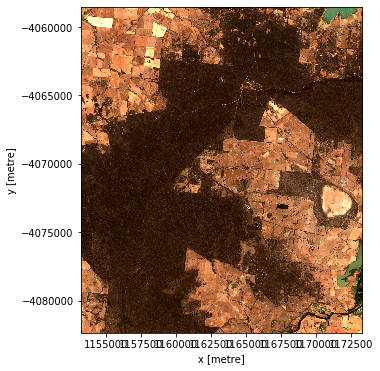

In [21]:
# Visualise median image as true colour image
rgb(median, bands=['nbart_red', 'nbart_green', 'nbart_blue'])

#### Apply model to median

In [22]:
# Dictionary mapping full data names to simpler 'red' alias names
bandnames_dict = {'nbart_red': 'red', 'nbart_green': 'green',
                  'nbart_blue': 'blue', 'nbart_nir_1': 'nir',
                  'nbart_swir_2': 'swir1', 'nbart_swir_3': 'swir2'}

# Rename bands in dataset to use simple names (e.g. 'red')
bands_to_rename = {a: b for a, b in bandnames_dict.items() if a in median.variables}

# Apply function after normalising to a 0.0-1.0 range by dividing by 10,000
renamed = median.rename(bands_to_rename)
renamed

<xarray.Dataset>
Dimensions:  (x: 2008, y: 2386)
Coordinates:
  * x        (x) float64 1.153e+06 1.153e+06 1.153e+06 ... 1.173e+06 1.173e+06
  * y        (y) float64 -4.059e+06 -4.059e+06 ... -4.082e+06 -4.082e+06
Data variables:
    blue     (y, x) float32 794.0 763.0 665.0 453.0 ... 1484.0 1492.0 1526.0
    green    (y, x) float32 1043.0 987.0 879.0 666.0 ... 2021.5 2017.5 2017.0
    red      (y, x) float32 1533.0 1400.0 1148.0 806.0 ... 3000.5 2996.5 3022.5
    nir      (y, x) float32 2483.0 2327.0 2237.0 2383.0 ... 4342.5 4322.0 4271.5
    swir1    (y, x) float32 3913.0 3913.0 2817.0 2817.0 ... 4223.0 4223.0 4216.5
    swir2    (y, x) float32 2732.0 2732.0 1802.0 1802.0 ... 2764.0 2764.0 2762.0

In [23]:
shp_renamed = renamed.to_array()
shp_renamed

<xarray.DataArray (variable: 6, y: 2386, x: 2008)>
array([[[ 794. ,  763. ,  665. , ...,  526. ,  603. ,  504. ],
        [ 785. ,  752. ,  457. , ...,  495. ,  525. ,  496. ],
        [ 802. ,  781. ,  541. , ...,  493. ,  570. ,  684. ],
        ...,
        [ 632. ,  648. ,  661. , ..., 1473.5, 1469. , 1474.5],
        [ 704. ,  625. ,  695. , ..., 1471. , 1478.5, 1471. ],
        [ 670. ,  668. ,  703. , ..., 1484. , 1492. , 1526. ]],

       [[1043. ,  987. ,  879. , ...,  662. ,  782. ,  632. ],
        [1061. ,  951. ,  589. , ...,  622. ,  693. ,  704. ],
        [1091. , 1033. ,  686. , ...,  607. ,  717. ,  894. ],
        ...,
        [ 905. ,  976. ,  949. , ..., 2008. , 1986. , 1971. ],
        [ 964. ,  930. ,  984. , ..., 1991.5, 1987.5, 1986.5],
        [ 928. ,  934. ,  999. , ..., 2021.5, 2017.5, 2017. ]],

       [[1533. , 1400. , 1148. , ...,  886. ,  997. ,  866. ],
        [1507. , 1344. ,  786. , ...,  816. ,  922. ,  977. ],
        [1548. , 1445. ,  989. , ...,  831. ,  951. , 1236. ],
        ...,
        [1387. , 1447. , 1486. , ..., 2982.5, 2965.5, 2934. ],
        [1443. , 1412. , 1497. , ..., 2964. , 2945.5, 2955. ],
        [1393. , 1425. , 1468. , ..., 3000.5, 2996.5, 3022.5]],

       [[2483. , 2327. , 2237. , ..., 2207. , 2256. , 2195. ],
        [2535. , 2213. , 1814. , ..., 2149. , 2269. , 2051. ],
        [2584. , 2400. , 1914. , ..., 2026. , 2306. , 2360. ],
        ...,
        [2430. , 2508. , 2429. , ..., 4274.5, 4233.5, 4197.5],
        [2575. , 2533. , 2467. , ..., 4235. , 4208.5, 4187. ],
        [2543. , 2429. , 2475. , ..., 4342.5, 4322. , 4271.5]],

       [[3913. , 3913. , 2817. , ..., 2570. , 2570. , 2982. ],
        [3913. , 3913. , 2817. , ..., 2648. , 2648. , 3095. ],
        [4097. , 4097. , 3112. , ..., 2648. , 2648. , 3095. ],
        ...,
        [3685. , 3696. , 3696. , ..., 4180. , 4180. , 4180. ],
        [3401. , 3653. , 3696. , ..., 4223. , 4223. , 4216.5],
        [3653. , 3653. , 3795. , ..., 4223. , 4223. , 4216.5]],

       [[2732. , 2732. , 1802. , ..., 1772. , 1772. , 2065. ],
        [2732. , 2732. , 1802. , ..., 1781. , 1781. , 2172. ],
        [2886. , 2886. , 2235. , ..., 1781. , 1781. , 2172. ],
        ...,
        [2643. , 2577. , 2577. , ..., 2746.5, 2746.5, 2744. ],
        [2408. , 2510. , 2577. , ..., 2764. , 2764. , 2762. ],
        [2510. , 2510. , 2704. , ..., 2764. , 2764. , 2762. ]]],
      dtype=float32)
Coordinates:
  * x         (x) float64 1.153e+06 1.153e+06 1.153e+06 ... 1.173e+06 1.173e+06
  * y         (y) float64 -4.059e+06 -4.059e+06 ... -4.082e+06 -4.082e+06
  * variable  (variable) <U5 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'

In [24]:
# Reshape for use in model
stacked = shp_renamed.stack(z=('x', 'y')).transpose()
stacked

<xarray.DataArray (z: 4791088, variable: 6)>
array([[ 794. , 1043. , 1533. , 2483. , 3913. , 2732. ],
       [ 785. , 1061. , 1507. , 2535. , 3913. , 2732. ],
       [ 802. , 1091. , 1548. , 2584. , 4097. , 2886. ],
       ...,
       [1474.5, 1971. , 2934. , 4197.5, 4180. , 2744. ],
       [1471. , 1986.5, 2955. , 4187. , 4216.5, 2762. ],
       [1526. , 2017. , 3022.5, 4271.5, 4216.5, 2762. ]], dtype=float32)
Coordinates:
  * variable  (variable) <U5 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'
  * z         (z) MultiIndex
  - x         (z) float64 1.153e+06 1.153e+06 1.153e+06 ... 1.173e+06 1.173e+06
  - y         (z) float64 -4.059e+06 -4.059e+06 ... -4.082e+06 -4.082e+06

In [25]:
# Unstack
stacked.transpose().unstack('z')

<xarray.DataArray (variable: 6, x: 2008, y: 2386)>
array([[[ 794. ,  785. ,  802. , ...,  632. ,  704. ,  670. ],
        [ 763. ,  752. ,  781. , ...,  648. ,  625. ,  668. ],
        [ 665. ,  457. ,  541. , ...,  661. ,  695. ,  703. ],
        ...,
        [ 526. ,  495. ,  493. , ..., 1473.5, 1471. , 1484. ],
        [ 603. ,  525. ,  570. , ..., 1469. , 1478.5, 1492. ],
        [ 504. ,  496. ,  684. , ..., 1474.5, 1471. , 1526. ]],

       [[1043. , 1061. , 1091. , ...,  905. ,  964. ,  928. ],
        [ 987. ,  951. , 1033. , ...,  976. ,  930. ,  934. ],
        [ 879. ,  589. ,  686. , ...,  949. ,  984. ,  999. ],
        ...,
        [ 662. ,  622. ,  607. , ..., 2008. , 1991.5, 2021.5],
        [ 782. ,  693. ,  717. , ..., 1986. , 1987.5, 2017.5],
        [ 632. ,  704. ,  894. , ..., 1971. , 1986.5, 2017. ]],

       [[1533. , 1507. , 1548. , ..., 1387. , 1443. , 1393. ],
        [1400. , 1344. , 1445. , ..., 1447. , 1412. , 1425. ],
        [1148. ,  786. ,  989. , ..., 1486. , 1497. , 1468. ],
        ...,
        [ 886. ,  816. ,  831. , ..., 2982.5, 2964. , 3000.5],
        [ 997. ,  922. ,  951. , ..., 2965.5, 2945.5, 2996.5],
        [ 866. ,  977. , 1236. , ..., 2934. , 2955. , 3022.5]],

       [[2483. , 2535. , 2584. , ..., 2430. , 2575. , 2543. ],
        [2327. , 2213. , 2400. , ..., 2508. , 2533. , 2429. ],
        [2237. , 1814. , 1914. , ..., 2429. , 2467. , 2475. ],
        ...,
        [2207. , 2149. , 2026. , ..., 4274.5, 4235. , 4342.5],
        [2256. , 2269. , 2306. , ..., 4233.5, 4208.5, 4322. ],
        [2195. , 2051. , 2360. , ..., 4197.5, 4187. , 4271.5]],

       [[3913. , 3913. , 4097. , ..., 3685. , 3401. , 3653. ],
        [3913. , 3913. , 4097. , ..., 3696. , 3653. , 3653. ],
        [2817. , 2817. , 3112. , ..., 3696. , 3696. , 3795. ],
        ...,
        [2570. , 2648. , 2648. , ..., 4180. , 4223. , 4223. ],
        [2570. , 2648. , 2648. , ..., 4180. , 4223. , 4223. ],
        [2982. , 3095. , 3095. , ..., 4180. , 4216.5, 4216.5]],

       [[2732. , 2732. , 2886. , ..., 2643. , 2408. , 2510. ],
        [2732. , 2732. , 2886. , ..., 2577. , 2510. , 2510. ],
        [1802. , 1802. , 2235. , ..., 2577. , 2577. , 2704. ],
        ...,
        [1772. , 1781. , 1781. , ..., 2746.5, 2764. , 2764. ],
        [1772. , 1781. , 1781. , ..., 2746.5, 2764. , 2764. ],
        [2065. , 2172. , 2172. , ..., 2744. , 2762. , 2762. ]]],
      dtype=float32)
Coordinates:
  * variable  (variable) <U5 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'
  * x         (x) float64 1.153e+06 1.153e+06 1.153e+06 ... 1.173e+06 1.173e+06
  * y         (y) float64 -4.059e+06 -4.059e+06 ... -4.082e+06 -4.082e+06

In [55]:
# Apply model to median
prediction_wcf = model.predict(stacked)

In [44]:
prediction_wcf

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [36]:
unflattened = sklearn_unflatten(prediction_wcf, renamed)

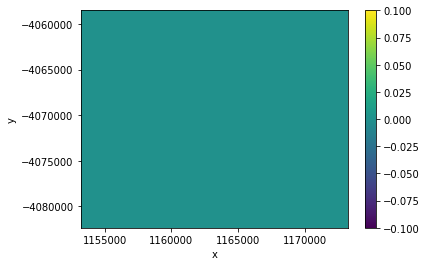

In [47]:
unflattened.transpose().plot()

In [50]:
# Predict landcover using the trained model
predicted = predict_xr(model, renamed, progress=True)
predicted

#predicted.plot(vmin=0,vmax=1)

<xarray.DataArray (y: 2386, x: 2008)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 1.153e+06 1.153e+06 1.153e+06 ... 1.173e+06 1.173e+06
  * y        (y) float64 -4.059e+06 -4.059e+06 ... -4.082e+06 -4.082e+06